# Programming Project #5: Video Stitching and Processing 

## CS445: Computational Photography - Fall 2019

### Part I: Stitch two key frames <img src="images/project_5/image005.jpg" alt="Drawing" style="float: right; width: 450px"/>

#### This involves:
1. compute homography H between two frames; 
2. project each frame onto the same surface;
3. blend the surfaces.



Check that your homography is correct by plotting four points that form a square in frame 270 and their projections in each image, like this:
<p>
    <img src="images/project_5/image002.jpg" alt="Drawing"/>
    <img src="images/project_5/image004.jpg" alt="Drawing"/>
</p>

In [78]:
import cv2
import numpy as np
from numpy.linalg import svd, inv

%matplotlib inline
from matplotlib import pyplot as plt

In [79]:
# images location
im1 = './images/input/frames/f0001.jpg'
im2 = './images/input/frames/f0270.jpg'

# Load an color image in grayscale
im1 = cv2.imread(im1)
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
im2 = cv2.imread(im2)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)

In [80]:
def auto_homography(Ia, Ib, homography_func=None, normalization_func=None):
    '''
    Computes a homography that maps points from Ia to Ib

    Input: Ia and Ib are images
    Output: H is the homography

    '''
    if Ia.dtype == 'float32' and Ib.dtype == 'float32':
        Ia = (Ia*255).astype(np.uint8)
        Ib = (Ib*255).astype(np.uint8)
    
    Ia_gray = cv2.cvtColor(Ia,cv2.COLOR_BGR2GRAY)
    Ib_gray = cv2.cvtColor(Ib,cv2.COLOR_BGR2GRAY)

    # Initiate SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()
    
    # find the keypoints and descriptors with SIFT
    kp_a, des_a = sift.detectAndCompute(Ia_gray,None)
    kp_b, des_b = sift.detectAndCompute(Ib_gray,None)   
    
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des_a,des_b, k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.85*n.distance:
            good.append(m)
   
    numMatches = int(len(good))

    matches = good

    # Xa and Xb are 3xN matrices that contain homogeneous coordinates for the N
    # matching points for each image
    Xa = np.ones((3,numMatches))
    Xb = np.ones((3,numMatches))
    
    for idx, match_i in enumerate(matches):
        Xa[:,idx][0:2] = kp_a[match_i.queryIdx].pt
        Xb[:,idx][0:2] = kp_b[match_i.trainIdx].pt

    ## RANSAC
    niter = 1000
    best_score = 0

    for t in range(niter):
        # estimate homography
        subset = np.random.choice(numMatches, 4, replace=False)
        pts1 = Xa[:,subset]
        pts2 = Xb[:,subset]
        
        H_t = homography_func(pts1, pts2) # , normalization_func) # edit helper code below (computeHomography)

        # score homography
        Xb_ = np.dot(H_t, Xa) # project points from first image to second using H
        du = Xb_[0,:]/Xb_[2,:] - Xb[0,:]/Xb[2,:]
        dv = Xb_[1,:]/Xb_[2,:] - Xb[1,:]/Xb[2,:]

        ok_t = np.sqrt(du**2 + dv**2) < 1  # you may need to play with this threshold
        score_t = sum(ok_t)

        if score_t > best_score:
            best_score = score_t
            H = H_t
            in_idx = ok_t
    
#     print('best score: {:02f}'.format(best_score))

    # Optionally, you may want to re-estimate H based on inliers
    return H

In [81]:
def computeHomography(pts1, pts2):
    '''
    Compute homography that maps from pts1 to pts2 using least squares solver
     
    Input: pts1 and pts2 are 3xN matrices for N points in homogeneous
    coordinates. 
    
    Output: H is a 3x3 matrix, such that pts2~=H*pts1
    '''
 
    A = np.zeros((8, 9))
    for idx in range(pts1.shape[1]):
        pt1 = pts1[:, idx]
        pt2 = pts2[:, idx]
        
        A[idx*2, 0]   = -pt1[0]
        A[idx*2, 1]   = -pt1[1]
        A[idx*2, 2]   = -1;
        A[idx*2, 6]   = pt1[0] * pt2[0]
        A[idx*2, 7]   = pt1[1] * pt2[0]
        A[idx*2, 8]   = pt2[0]
        
        A[idx*2+1, 3] = -pt1[0]
        A[idx*2+1, 4] = -pt1[1]
        A[idx*2+1, 5] = -1
        A[idx*2+1, 6] = pt1[0] * pt2[1]
        A[idx*2+1, 7] = pt1[1] * pt2[1]
        A[idx*2+1, 8] = pt2[1]
        
    U, S, V = svd(A)
    H = V[-1, :].reshape((3, 3))

    return H

In [82]:
H = auto_homography(im1,im2, homography_func=computeHomography)

In [83]:
def get_translation(im1, im2, H):
    height, width, _ = im1.shape
    
    border_pts = np.asarray([
        [0, 0, width-1, width-1],
        [0, height-1, 0, height-1],
        [1, 1, 1, 1]])
    border_pts = border_pts / border_pts[-1, :]
    cvt_border_pts = np.dot(H, border_pts)
    cvt_border_pts = cvt_border_pts / cvt_border_pts[-1, :]
    
    # Mapped coords w.r.t ref. image
    x_min, x_max = np.min(cvt_border_pts[0, :]), np.max(cvt_border_pts[0, :])
    y_min, y_max = np.min(cvt_border_pts[1, :]), np.max(cvt_border_pts[1, :])
    
    # im1 coords after translation
    x_translate = max(0, -x_min); y_translate = max(0, -y_min)
    im2_x_max = x_max + x_translate
    im2_y_max = y_max + y_translate
    
    H_translate = np.eye(3)
    H_translate[0, -1] = x_translate; H_translate[1, -1] = y_translate
    
    anchor_trans = np.dot(H_translate, border_pts)
    anchor_trans = anchor_trans / anchor_trans[-1, :]
    
    im2_x_max = int(max(im2_x_max, anchor_trans[0, 3]))
    im2_y_max = int(max(im2_y_max, anchor_trans[1, 3]))

    return H_translate, (x_min, im2_x_max, y_min, im2_y_max)

In [84]:
def stitching(im1, im2, H_rotate, H_translate, width, height, stitch=True):
    H_whole = np.dot(H_translate, H_rotate)
    img_anchor  = cv2.warpPerspective(im2, H_translate, (width+1, height+1))
    img_wrapped = cv2.warpPerspective(im1, H_whole,     (width+1, height+1))
    
    if stitch:
        img_stitched = img_wrapped
        occupied = np.sum(img_wrapped, axis=-1) > 0

        for h in range(img_stitched.shape[0]):
            for w in range(img_stitched.shape[1]):
                if not occupied[h, w]:
                    img_stitched[h, w] = img_anchor[h, w]
        return img_stitched
    else:
        return img_wrapped

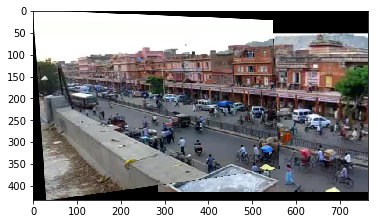

True

In [86]:
H_trans, (x_min, x_max, y_min, y_max) = get_translation(im1, im2, H)
img = stitching(im1, im2, H, H_trans, x_max, y_max)
plt.imshow(img)
plt.show()

img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2.imwrite("0_270_blended.jpg", img)

### Part II: Panorama using five key frames

In this part you will produce a panorama using five key frames. Let's determine frames [90, 270, 450, 630, 810] as key frames. The goal is to map all the five frames onto the plane corresponding to frame 450 (that we also call the _reference frame_). For the frames 270 and 630 you can follow the instructions in part 1.

<img src="images/project_5/header.jpg" alt="Drawing" style="float: center; width: 500px"/>

Mapping frame 90 to frame 450 is difficult because they share very little area. Therefore you need to perform a two stage mapping by using frame 270 as a guide. Compute one projection from 90 to 270 and one from 270 to 450 and multiply the two matrices. This produces a projection from 90 to 450 even though these frames have very little area in common



In [87]:
import cv2
import numpy as np

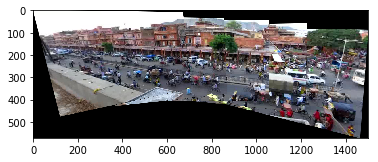

True

In [88]:
master_frames =[90, 270, 450, 630, 810]
reference_frame = 450
reference_idx = master_frames.index(reference_frame)

im_paths = ['./images/input/frames/f0090.jpg',
            './images/input/frames/f0270.jpg',
            './images/input/frames/f0450.jpg',
            './images/input/frames/f0630.jpg',
            './images/input/frames/f0810.jpg']

imgs = [cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB) for p in im_paths]
im_height, im_width, _ = imgs[0].shape

H_90_270  = auto_homography(imgs[0], imgs[1], homography_func=computeHomography)
H_270_450 = auto_homography(imgs[1], imgs[2], homography_func=computeHomography)
H_630_450 = auto_homography(imgs[3], imgs[2], homography_func=computeHomography)
H_810_630 = auto_homography(imgs[4], imgs[3], homography_func=computeHomography)
H_90_450  = np.dot(H_90_270, H_270_450)
H_810_450 = np.dot(H_630_450, H_810_630)

H_trans_90_450,  coords_90_450  = get_translation(imgs[0], imgs[2], H_90_450)
H_trans_270_450, coords_270_450 = get_translation(imgs[1], imgs[2], H_270_450)
H_trans_810_450, coords_810_450 = get_translation(imgs[4], imgs[2], H_810_450)

width  = int(coords_810_450[1] - coords_90_450[0])
height = int(coords_810_450[3] - coords_90_450[2])

I_90_450  = stitching(imgs[0], imgs[2], H_90_450,  H_trans_90_450, width, height, stitch=False)
I_270_450 = stitching(imgs[1], imgs[2], H_270_450, H_trans_90_450, width, height)
I_630_450 = stitching(imgs[3], imgs[2], H_630_450, H_trans_90_450, width, height, stitch=False)
I_810_450 = stitching(imgs[4], imgs[2], H_810_450, H_trans_90_450, width, height, stitch=False)

img = I_90_450
for im in [I_270_450, I_630_450, I_810_450]:
    filled = np.sum(img, axis=-1) > 0
    for h in range(img.shape[0]):
        for w in range(img.shape[1]):
            if not filled[h, w]:
                img[h, w] = im[h, w]
                
plt.imshow(img)
plt.show()
cv2.imwrite("panorama.jpg", cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

### Part 3: Map the video to the reference plane

In [45]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from math import floor

import utils

In [426]:
dir_frames = 'images/input/frames'
filesinfo = os.scandir(dir_frames)

In [427]:
filenames = [f.path for f in filesinfo if f.name.endswith(".jpg")]
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

In [428]:
frameCount = len(filenames)
frameHeight, frameWidth, frameChannels = cv2.imread(filenames[0]).shape
frames = np.zeros((frameCount, frameHeight, frameWidth, frameChannels),dtype=np.float32)

In [429]:
for idx, file_i in enumerate(filenames):
    frames[idx] = cv2.cvtColor(cv2.imread(file_i), cv2.COLOR_BGR2RGB) / 255.0

In [322]:
## Example usage of utils.projectImage

pastHomographies = np.zeros((len(filenames),len(filenames), 3, 3),dtype=np.float32)
originTranslations = np.zeros((len(filenames), 2), dtype=np.float32)
sourceFrameIndex = 630
referenceFrameIndex = 450

In [325]:
projectedSource, _, originTranslations = utils.projectImage(frames, sourceFrameIndex, referenceFrameIndex,
                                                            pastHomographies, originTranslations,
                                                            auto_H_func=auto_homography, homography_func=computeHomography)

Overlap:110924
Error:0.0003923808090779779


In [326]:
projectedReference, _, originTranslations = utils.projectImage(frames, referenceFrameIndex, referenceFrameIndex,
                                                               pastHomographies, originTranslations,
                                                               auto_H_func=auto_homography, homography_func=computeHomography)

Overlap:169855
Error:0.0


In [327]:
blendedOutput = utils.blendImages(projectedSource, projectedReference)

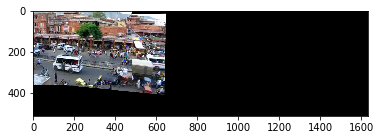

In [328]:
plt.imshow(blendedOutput)

In [447]:
ref_frame = frames[450-1]
frame_no = np.array([90, 270, 450, 630, 810])
H_to_450 = [H_90_450, H_270_450, np.eye(3), H_630_450, H_810_450]

# saved_H = np.zeros((len(frames), 3, 3))
saved_H = np.load("H.npy")

H_trans_1st = None
for idx, frame in enumerate(frames):
        
    closest = np.argmin(np.abs(frame_no - idx - 1))
    f_no = frame_no[closest]
    
    inter_ref = frames[f_no - 1]
    H_inter = auto_homography(frame, inter_ref, homography_func=computeHomography)
    H_450 = np.dot(H_inter, H_to_450[closest])
    
    H_trans_450, coords_450 = get_translation(frame, ref_frame, H_450)
    
    if H_trans_1st is None:
        H_trans_1st = H_trans_450
        
    saved_H[idx] = np.dot(H_trans_1st, H_450)
    
    I = stitching(frame, ref_frame, H_450, H_trans_1st, width, height, stitch=False)
    I = cv2.cvtColor(I, cv2.COLOR_RGB2BGR)
    
    cv2.imwrite('aligned_frames/a{:04d}.jpg'.format(idx+1), (I*255).astype(np.uint8))
    print(f'Done with image idx {idx}', end='\r')

In [448]:
np.save("H.npy", saved_H)

In [452]:
for p in os.listdir("aligned_frames"):
    p = os.path.join("aligned_frames", p)
    img = cv2.imread(p)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(p, img)

In [464]:
utils.imageFolder2mpeg('aligned_frames', fps=30)

### Part 4: Create background panorama

In this part you will remove moving objects from the video and create a background panorama that should incorporate pixels from all the frames.

In the video you produced in __part 3__ each pixel appears in several frames. You need to estimate which of the many colors correspond to the background. We take advantage of the fact that the background color is fixed while the foreground color changes frequently (because foreground moves).

<img src="images/project_5/background.jpg" alt="Drawing" style="float: center; width: 500px"/>


For each pixel in the sequence of __part 3__, determine all valid colors (colors that come from all frames that overlap that pixel). You can experiment with different methods for determining the background color of each pixel, as discussed in class. Perform the same procedure for all pixels and generate output. The output should be a completed panorama showing only pixels of background or non-moving objects.

In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [29]:
import time

dir_frames = 'aligned_frames'
pano_filesinfo = os.scandir(dir_frames)
pano_filenames = [f.path for f in pano_filesinfo if f.name.endswith(".jpg")]
pano_filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

img = cv2.cvtColor(cv2.imread(pano_filenames[0]), cv2.COLOR_BGR2RGB)
pano_height, pano_width, _ = img.shape

# # Mean pixel value
# px_sum = np.zeros_like(img, dtype=np.float64)
# mask_sum = np.zeros((height, width), dtype=np.float32)

# for file_i in pano_filenames:
#     print(f'Processing {file_i}...', end='\r')
#     img = cv2.cvtColor(cv2.imread(file_i), cv2.COLOR_BGR2RGB)
#     mask = np.sum(img, axis=-1) > 0
#     mask_sum += mask
#     px_sum += img
    
# mask_sum = np.repeat(mask_sum[:, :, np.newaxis], 3, axis=-1)
# px_sum /= mask_sum
# plt.imshow(px_sum.astype(np.uint8))
# plt.show()

# Median
pixels = {}
masks = np.zeros((len(pano_filenames), pano_height, pano_width), dtype=np.bool)
for idx, file_i in enumerate(pano_filenames):
    start = time.time()
    
    print(f'Processing {file_i}...', end='\r')
    img = cv2.imread(file_i)
    masks[idx] = np.sum(img, axis=-1) > 0
    
    h_ind, w_ind = np.where(masks[idx] == 1)
    for h, w in zip(h_ind, w_ind):
        if pixels.get((h, w), None) is None:
            pixels[(h, w)] = []
        pixels[(h, w)].append(img[h, w])

In [ ]:
bg = np.zeros((pano_height, pano_width, 3), dtype=np.uint8)  
for key, val_list in pixels.items():
    h, w = key
    bg[h, w] = np.median(val_list, axis=0)
              
plt.imshow(cv2.cvtColor(bg, cv2.COLOR_BGR2RGB))
plt.show()
cv2.imwrite("bg_median.jpg", bg)

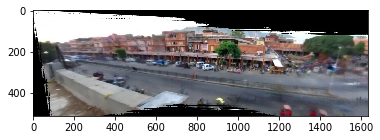

In [90]:
img = cv2.imread("bg_median.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

### Part 5: Create background movie

Map the background panorama to the movie coordinates. For each frame of the movie, say frame 1, you need to estimate a projection from the panorama to frame 1. Note, you should be able to re-use the homographies that you estimated in __Part 3__. Perform this for all frames and generate a movie that looks like the input movie but shows only background pixels. All moving objects that belong to the foreground must be removed.

In [ ]:
import os
import cv2
import numpy as np

In [35]:
pano = cv2.imread("bg_median.jpg")

os.makedirs("background_frames", exist_ok=True)
H_saved = np.load("H.npy")
for idx, H in enumerate(H_saved):
    inv_H = inv(H)
    inv_img = cv2.warpPerspective(pano, inv_H, (im_width, im_height))
    cv2.imwrite('background_frames/a{:04d}.jpg'.format(idx+1), inv_img)

In [38]:
utils.imageFolder2mpeg('background_frames', fps=30)

### Part 6: Create foreground movie

In the background video, moving objects are removed. In each frame, those pixels that are different enough than the background color are considered foreground. For each frame determine foreground pixels and generate a movie that only includes foreground pixels.

In [9]:
import os
import cv2
import numpy as np
from scipy.ndimage.filters import convolve

In [75]:
dir_background = 'background_frames'
dir_original = 'images/input/frames'

ksize = 5
threshold = 75
for idx, p in enumerate(sorted(os.listdir(dir_background))):
    print(f'Processing {p}...', end='\r')
    
    num = ''.join(filter(str.isdigit, p))
    bg_frame_p = os.path.join(dir_background, p)
    ori_frame_p = os.path.join(dir_original, f'f{num}.jpg')
    
    bg_frame = cv2.cvtColor(cv2.imread(bg_frame_p), cv2.COLOR_BGR2RGB).astype(np.float32)
    ori_frame = cv2.cvtColor(cv2.imread(ori_frame_p), cv2.COLOR_BGR2RGB).astype(np.float32)

    diff = np.sqrt(np.sum(np.power(bg_frame - ori_frame, 2), axis=-1))
    mask = diff > threshold
    mask = convolve(mask.astype(np.float32), np.ones((ksize,ksize))/(ksize*ksize))
    mask = np.repeat(mask[:, :, np.newaxis], 3, axis=-1)
    
    fg_frame = np.array(ori_frame) * mask    
    fg_frame = cv2.cvtColor(fg_frame, cv2.COLOR_RGB2BGR)
    cv2.imwrite('foreground_frames/a{:04d}.jpg'.format(idx+1), fg_frame)

In [76]:
utils.imageFolder2mpeg('foreground_frames', fps=30)

## Bells and whistles